In [ ]:
from __future__ import annotations

import glob
import os
import time

from pettingzoo.test import api_test
import pettingzoo
import gymnasium as gym

from sb3_contrib import MaskablePPO
from sb3_contrib.common.maskable.policies import MaskableActorCriticPolicy
from sb3_contrib.common.wrappers import ActionMasker

from lib.briscola_env.briscola_env import BriscolaEnv

In [2]:
PLAYER_COUNT = 2
NUM_TRAINING_STEPS = 1_000_000
NUM_EVAL_GAMES = 1000


def make_env():
	return BriscolaEnv(num_players=PLAYER_COUNT)

api_test(make_env(), num_cycles=1000)


Starting API test
Passed API test


/home/tim/src/briscola-py/.venv/lib/python3.11/site-packages/pettingzoo/test/api_test.py:242: UserWarning: Observation space for each agent probably should be gymnasium.spaces.box or gymnasium.spaces.discrete
  warnings.warn(
/home/tim/src/briscola-py/.venv/lib/python3.11/site-packages/pettingzoo/test/api_test.py:140: UserWarning: Observation is not a NumPy array
  warnings.warn("Observation is not a NumPy array")
/home/tim/src/briscola-py/.venv/lib/python3.11/site-packages/pettingzoo/test/api_test.py:660: UserWarning: Environment has not defined a render() method
  warnings.warn("Environment has not defined a render() method")


In [3]:
# To pass into other gymnasium wrappers, we need to ensure that pettingzoo's wrappper
# can also be a gymnasium Env. Thus, we subclass under gym.Env as well.
class SB3ActionMaskWrapper(pettingzoo.utils.BaseWrapper, gym.Env):
    """Wrapper to allow PettingZoo environments to be used with SB3 illegal action masking."""

    def reset(self, seed=None, options=None):
        """Gymnasium-like reset function which assigns obs/action spaces to be the same for each agent.

        This is required as SB3 is designed for single-agent RL and doesn't expect obs/action spaces to be functions
        """
        super().reset(seed, options)

        # Strip the action mask out from the observation space
        self.observation_space = super().observation_space(self.possible_agents[0])[
            "observation"
        ]
        self.action_space = super().action_space(self.possible_agents[0])

        # Return initial observation, info (PettingZoo AEC envs do not by default)
        return self.observe(self.agent_selection), {}

    def step(self, action):
        """Gymnasium-like step function, returning observation, reward, termination, truncation, info.

        The observation is for the next agent (used to determine the next action), while the remaining
        items are for the agent that just acted (used to understand what just happened).
        """
        current_agent = self.agent_selection

        super().step(action)

        next_agent = self.agent_selection
        return (
            self.observe(next_agent),
            self._cumulative_rewards[current_agent],
            self.terminations[current_agent],
            self.truncations[current_agent],
            self.infos[current_agent],
        )

    def observe(self, agent):
        """Return only raw observation, removing action mask."""
        return super().observe(agent)["observation"]

    def action_mask(self):
        """Separate function used in order to access the action mask."""
        return super().observe(self.agent_selection)["action_mask"]

In [4]:
def mask_fn(env):
    return env.action_mask()

def train(
    steps: int = 10_000, seed: int | None = 0, **env_kwargs
):
    # Train a single model to play as each agent in a cooperative Parallel environment
    env = make_env()
    env = SB3ActionMaskWrapper(env)
    env.reset(seed=seed)
    env = ActionMasker(env, mask_fn)

    print(f"Starting training on {str(env.metadata)}.")
    model = MaskablePPO(
        MaskableActorCriticPolicy, 
        env, 
        verbose=1,
        learning_rate=3e-4,
        ent_coef=0.001,
        vf_coef=0.65, 
    )
    model.set_random_seed(seed)
    model.learn(total_timesteps=steps)
    model.save(f"{env.unwrapped.metadata.get('name')}_{time.strftime('%Y%m%d-%H%M%S')}")

    print("Model has been saved.")
    print(f"Finished training on {str(env.unwrapped.metadata['name'])}.\n")
    env.close()



In [5]:
train(steps=NUM_TRAINING_STEPS)

Starting training on {'render_modes': []}.
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 40       |
|    ep_rew_mean     | 1.23e+03 |
| time/              |          |
|    fps             | 340      |
|    iterations      | 1        |
|    time_elapsed    | 6        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 40           |
|    ep_rew_mean          | 1.25e+03     |
| time/                   |              |
|    fps                  | 278          |
|    iterations           | 2            |
|    time_elapsed         | 14           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0010547123 |
|    clip_fraction        | 0            |
|    c

In [6]:
# Evaluation Code

def make_results(agents, wins, total_rewards):
    player_results = []
    print("Winrates:")
    for p in agents:
        if sum(wins.values()) > 0:
            winrate = wins[p] / sum(wins.values())
        print(f"\t{p}: {winrate*100}%")
        print(f"\tWins: {wins[p]} Rewards: {total_rewards[p]}")
        player_results.append({"winrate": winrate, "total_rewards": total_rewards[p]})
    return player_results

def eval_action_mask(player, num_games=100):
    # Evaluate a trained agent vs a random agent
    env = make_env()
    print("Starting evaluation vs random agents.")
    if player != -1:
        print(f"Trained agent will play as {env.possible_agents[player]}")
    try:
        latest_policy = max(
            glob.glob(f"{env.metadata['name']}*.zip"), key=os.path.getctime
        )
    except ValueError:
        print("Policy not found.")
        raise
    print("Using policy:", latest_policy)
    model = MaskablePPO.load(latest_policy)

    wins = {agent: 0 for agent in env.possible_agents}
    total_rewards = {agent: 0 for agent in env.possible_agents}
    for i in range(num_games):
        env.reset(seed=i)
        for agent in env.agent_iter():
            obs, reward, termination, truncation, info = env.last()
            observation, action_mask = obs.values()
            if termination or truncation:
                winner = max(env.rewards, key=env.rewards.get)
                wins[winner] += env.infos[winner]["wins"] 
                for a in env.possible_agents:
                    total_rewards[a] += env.rewards[a]
                break
            else:
                # Act randomly unless it's the agents turn
                if agent != env.possible_agents[player] or player == -1:
                    act = env.action_space(agent).sample(action_mask)
                else:
                    act = int(
                        model.predict(
                            observation, action_masks=action_mask, deterministic=True
                        )[0]
                    )
            env.step(act)
    env.close()
    return make_results(env.agents, wins, total_rewards)


In [7]:

baseline_results = eval_action_mask(-1, num_games=NUM_EVAL_GAMES)
results_by_position = []
for position in range(PLAYER_COUNT):
	results_by_position.append(eval_action_mask(position, num_games=NUM_EVAL_GAMES))

Starting evaluation vs random agents.
Using policy: briscola_20250428-223624.zip
Winrates:
	player_0: 56.10000000000001%
	Wins: 561 Rewards: 131097
	player_1: 43.9%
	Wins: 439 Rewards: 108903
Starting evaluation vs random agents.
Trained agent will play as player_0
Using policy: briscola_20250428-223624.zip
Winrates:
	player_0: 50.8%
	Wins: 508 Rewards: 122393
	player_1: 49.2%
	Wins: 492 Rewards: 117607
Starting evaluation vs random agents.
Trained agent will play as player_1
Using policy: briscola_20250428-223624.zip
Winrates:
	player_0: 52.900000000000006%
	Wins: 529 Rewards: 125854
	player_1: 47.099999999999994%
	Wins: 471 Rewards: 114146


In [8]:
import matplotlib.pyplot as plt
import numpy as np

def make_plot(winrate_data, title):
	winrates = np.transpose(np.array([
		[entry['winrate'] for entry in sublist] 
		for sublist in winrate_data
   	]))
	print(winrate_data, winrates)
	# Plot
	fig, ax = plt.subplots(figsize=(8, 6))

	# How many groups and bars
	num_positions, num_players = winrates.shape
	x = np.arange(num_players)

	# Width of each bar group
	bar_width = 0.2
	
	# Plot each group's bars
	for i in range(num_positions):
		ax.bar(x + i * bar_width, winrates[i], width=bar_width, label=f'Player {i}')

	# Labels and stuff
	ax.set_xlabel('Model Position')
	ax.set_ylabel('Winrate')
	ax.set_title(title)
	ax.set_xticks(x + bar_width * (num_positions-1) / 2)
	ax.set_xticklabels([str(i) for i in range(num_players)])
	ax.legend()

	plt.tight_layout()
	plt.show()
	plt.close(fig)


[[{'winrate': 0.561, 'total_rewards': 131097}, {'winrate': 0.439, 'total_rewards': 108903}]] [[0.561]
 [0.439]]


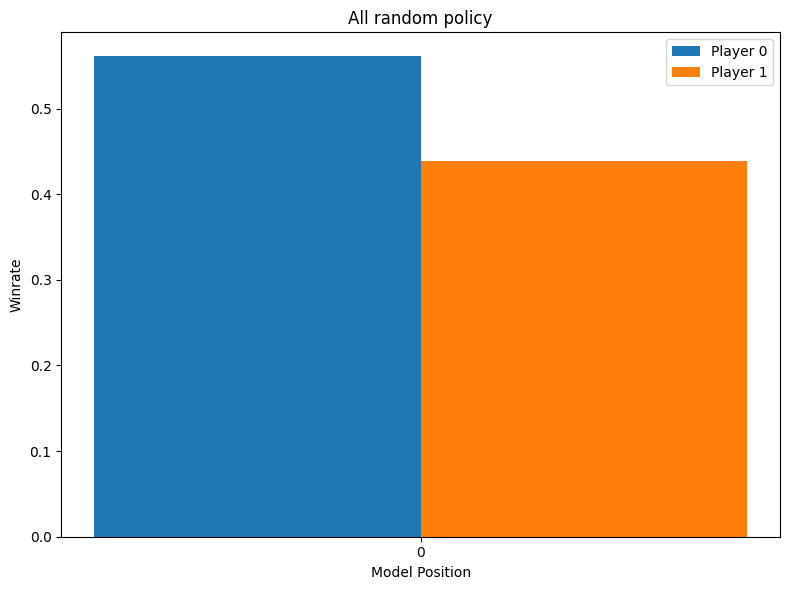

[[{'winrate': 0.508, 'total_rewards': 122393}, {'winrate': 0.492, 'total_rewards': 117607}], [{'winrate': 0.529, 'total_rewards': 125854}, {'winrate': 0.471, 'total_rewards': 114146}]] [[0.508 0.529]
 [0.492 0.471]]


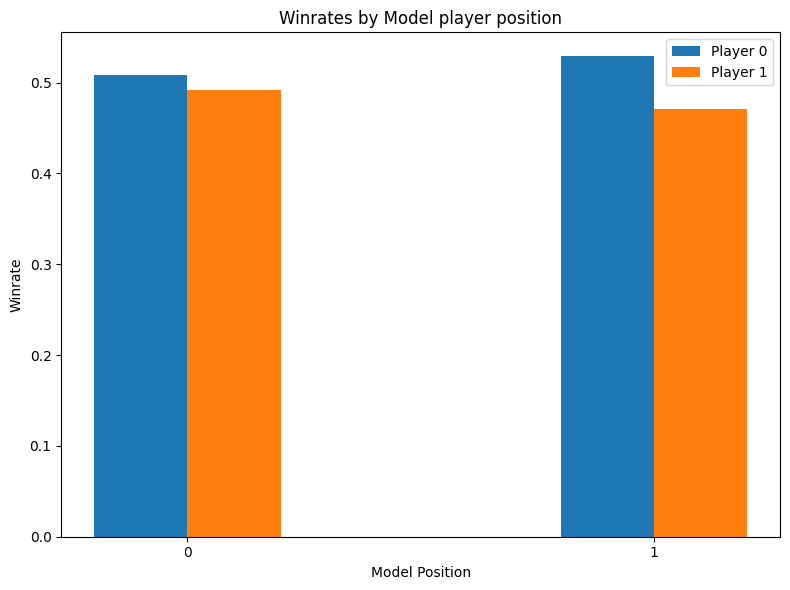

In [9]:
make_plot([baseline_results], "All random policy")
make_plot(results_by_position, "Winrates by Model player position")